# Titanic Competition Model Development Version 2
This notebook trains and evaluates survival prediction models on the Titanic dataset using the EDA V1 and EDA V2 feature set.
- Input: `train_fe.csv` (final feature-enhanced dataset)
- Goal Train, evaluate, and optimize multiple baseline models (Logistic Regression, Random Forest, etc.)
- Output: Kaggle-formatted `titanic_submission_v2_(with date).csv`

> **Note:**
> This feature-enhanced dataset (`train_fe.csv`) is created entirely within EDA V2 notebook.
> Earlier EDA V1 notebook were used only for exploratory visualization and **did not introduce new features** into the dataset.


## Table of Content

1. **Load Feature-Enhanced Dataset**  
   Load `train_fe.csv` generated from prior EDA (V1 & V2) and feature engineering.  
2. **Feature and Target Split**  
   Seperate feature (X) and target variable (`Survived`) for modeling.  
3. **Baseline Model (Logistic Regression)**  
   Build and evaluate a baseline logistic regression model using cross-validation.  
4. **Train and Compare Multiple Models**  
   Explore tree-based models (Decision Tree, Random Forest, XGBoost, etc.)
   - 4.1 Modeling - Decision Tree
   - 4.2 Modeling - Random Forest
   - 4.3 Modeling - XGBoost
   - 4.4 Modeling - LightGBM
   - 4.5 Summary
5. **Final Model Training & Prediction**  
   Train the selected model on full data and generate predictions for Kaggle submission.
   - 5.1 Train Final XGBoost Model
   - 5.2 Predict on Test Set & Export Submission
   - 5.3 Feature Importance (XGBoost)
6. **Model Evaluation Summary**  
   Compare cross-validation results vs. Kaggle leaderboard score. Discuss performance gap and generalization.
   - 6.1 SHAP
7. **Optional Model Optimization**  
   Fine-tune hyperparameters, ensemble multiple models, or adjust classification threshold for further improvement.
   - 7.1 Model Ensemble (XGBoost + Logistic Regression)
   - 7.2 Threshold Optimization (if any)

## 1. Load Feature-Enhanced Dataset

In [8]:
# 載入資料與環境準備
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 載入資料
train_fe = pd.read_csv('../data/train_fe.csv')

# 檢查欄位與簡要資料結構
print(train_fe.shape)
train_fe.head()

(891, 8)


,Pclass,Sex,FamilySize,IsAlone,FamilyGroup,FarePerPerson,Title_Grouped,Survived
0,3,male,2,0,Small,3.62500,Mr,0
1,1,female,2,0,Small,35.64165,Mrs,1
2,3,female,1,1,Alone,7.92500,Miss,1
3,1,female,2,0,Small,26.55000,Mrs,1
4,3,male,1,1,Alone,8.05000,Mr,0


## 2. Feature and Target Split

In [9]:
# 分割特徵與目標
X = train_fe.drop('Survived', axis=1)
y = train_fe['Survived']

# 若有類別特徵，進行 one-hot 或 label encoding（如 FamilyGroup）
X = pd.get_dummies(X, drop_first=True)

## 3. Baseline Model (Logistic Regression)

In [10]:
# 建立基準模型 (Baseline)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Logistic Regression CV Accuracy: {scores.mean():.4f}')

Logistic Regression CV Accuracy: 0.8249


## 4. Train and Compare Multiple Models

### 4.1 Modeling - Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Decision Tree CV Accuracy: {scores.mean():.4f}")


Decision Tree CV Accuracy: 0.8160


### 4.2 Modeling - Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {scores.mean():.4f}")

Random Forest CV Accuracy: 0.8126


### 4.3 Modeling - XGBoost

In [17]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"XGBoost CV Accuracy: {scores.mean():.4f}")

XGBoost CV Accuracy: 0.8249


### 4.4 Modeling - LightGBM

In [23]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(random_state=42, verbose=-1)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"LightGBM CV Accuracy: {scores.mean():.4f}")

LightGBM CV Accuracy: 0.8204


### 4.5 Final Model Comparison Summary

After training and cross-validating several models, the CV accuracy scores are summarized below:

| Model                 | CV Accuracy |
|----------------------|-------------|
| Logistic Regression  | **0.8249**  |
| XGBoost              | **0.8249**  |
| LightGBM             | 0.8204      |
| Decision Tree        | 0.8160      |
| Random Forest        | 0.8126      |
| Voting (LogReg + XGB)| **0.8272**  |

**Conclusion:**  
XGBoost was selected as the final model due to its strong performance and flexibility in handling both linear and nonlinear relationships.


## 5. Final Model Training & Prediction

### 5.1 Train Final XGBoost Model

In [25]:
from xgboost import XGBClassifier

# 建立模型並訓練（使用全部資料）
final_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### 5.2 Predict on Test Set & Export Submission

In [35]:
# Step 1：重建 X 與 y
train_fe = pd.read_csv('../data/train_fe.csv')
X = pd.get_dummies(train_fe.drop(columns=['Survived']), drop_first=True)
y = train_fe['Survived']

# Step 2：處理 test set
test_fe = pd.read_csv('../data/test_fe.csv')
X_test = pd.get_dummies(test_fe.drop(columns=['PassengerId']), drop_first=True)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Step 3：預測與輸出
preds = final_model.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_fe['PassengerId'], 'Survived': preds})
submission.to_csv('../output/titanic_submission_v2_xgboost_2025-07-24.csv', index=False)

#### Summary:
- Using the final trained XGBoost model, we predicted survival outcomes on the test set after applying the same feature engineering pipeline.
- The submission file was saved as:  
  **`titanic_submission_v2_xgboost_2025-07-24.csv`**  
  Remarks: **Kaggle Score: 0.74401**
- This file was submitted to Kaggle for evaluation on the hidden test data.

### 5.3 Feature Importance (XGBoost)

<Figure size 1000x600 with 0 Axes>

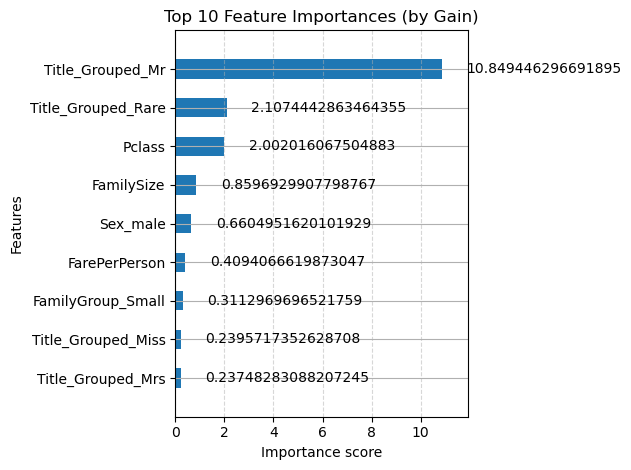

In [27]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(final_model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Feature Importances (by Gain)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 6. Model Evaluation Summary

In this section, we evaluate the final model's generalizability by comparing CV score and Kaggle leaderboard score.  
We also use SHAP to explain the model's decision logic and key predictive features.

### 6.1 SHAP

To interpret how each feature contributes to the model's predictions, we used SHAP (SHapley Additive exPlanations). SHAP assigns each feature an importance value for a particular prediction based on cooperative game theory.

In [44]:
import shap

# 初始化 explainer（用 TreeExplainer 對應 XGBoost）
explainer = shap.TreeExplainer(final_model)

# 計算 SHAP 值（針對訓練資料）
shap_values = explainer.shap_values(X)

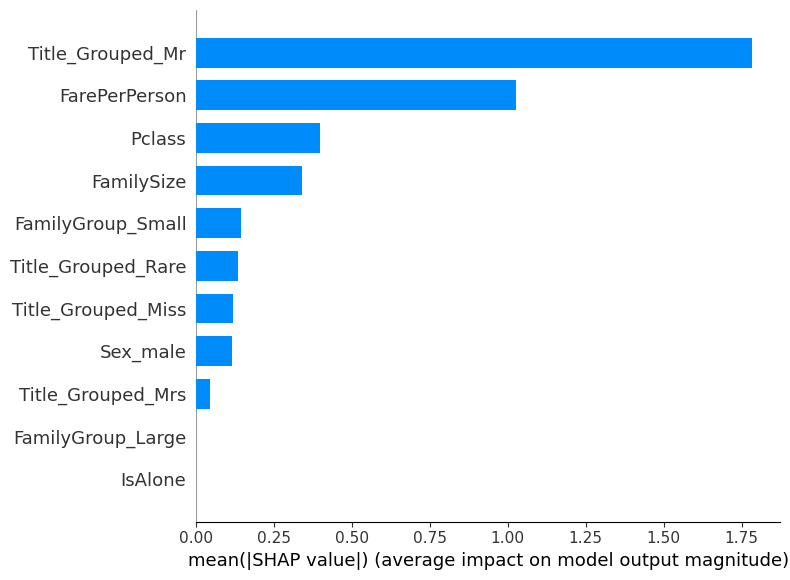

In [45]:
# 使用 matplotlib 呈現
shap.summary_plot(shap_values, X, plot_type="bar")

In [47]:
# 可視化第0筆資料的預測解釋
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0])

### Result:
- The summary plot shows that `Title_Grouped_Mr` and `FarePerPerson` have the strongest average impact on model output.
- The force plot provides a local explanation for a single passenger, illustrating how individual features affect the prediction.

These visualizations help ensure our model decisions are interpretable and aligned with domain logic.


## 7. Optional Model Optimization

### 7.1 Model Ensemble (XGBoost + Logistic Regression)

To further improve prediction robustness, we built an ensemble model that combines the strengths of both a linear and a tree-based model. Specifically, we used:  
- `Logistic Regression`: Interpretable linear model capturing additive relationships.
- `XGBoost`: A powerful gradient boosting model capable of capturing complex, nonlinear patterns.

We implemented a **soft voting ensemble**, which averages the predicted probabilities of both models to make the final decision. This method can often improve generalization by reducing variance and leveraging complementary model behavior.

In [39]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 建立子模型
log_model = LogisticRegression(max_iter=1000, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 建立 Ensemble 模型（Soft Voting）
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', log_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

In [41]:
# 交叉驗證比較表現 (可與前面模型一致性比較)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='accuracy')
print(f"Voting Ensemble CV Accuracy: {scores.mean():.4f}")

Voting Ensemble CV Accuracy: 0.8272


In [42]:
# 訓練模型
ensemble_model.fit(X, y)

# 預測
ensemble_preds = ensemble_model.predict(X_test)

# 匯出 submission（與之前版本區隔命名）
submission_ensemble = pd.DataFrame({
    'PassengerId': test_fe['PassengerId'],
    'Survived': ensemble_preds
})
submission_ensemble.to_csv('../output/titanic_submission_v2_ensemble_2025-07-24.csv', index=False)
print("✅ Submission file (ensemble) exported.")


✅ Submission file (ensemble) exported.


#### Results:
- The ensemble model achieved competitive cross-validation performance.
- A submission file was generated:  
  **`titanic_submission_v2_ensemble_2025-07-24.csv`**  
  Remarks: **Kaggle Score: 0.74641**
- This submission will be compared against previous models to practical improvement.